7/21/2024\
Author: Michael Stoll\
\
This assignment is going to look a lot like the HPO assignment. The only real change that you will notice is the addition of the preprocessing steps in both the search cells and the search space cell. I will point them out when we get to that point.\
\
As was the objective previously, I am in search of the set of hyperparameters that leads to the regressor with the higest r-squared score. That set is now expanded to include the parameters for each of the preprocessing tools I've used as well.\
\
For the sake of keeping things simple, I've elected to stick with the red wine quality data set. This being (likely) the last time I'm going to look at this particular dataset, I'd like to take the opportunity to lament the lack of brand names or other identifying marks. I know it must be to maintain anonymity but it would be nice to be able to use ML to find the next brand I'm going to try. I digress.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv("winequality-red.csv", sep=",")
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


As I am in the habit of doing, I'd like to show a correlation map now, just as a refresher of how the different features and the target correlate with one another.

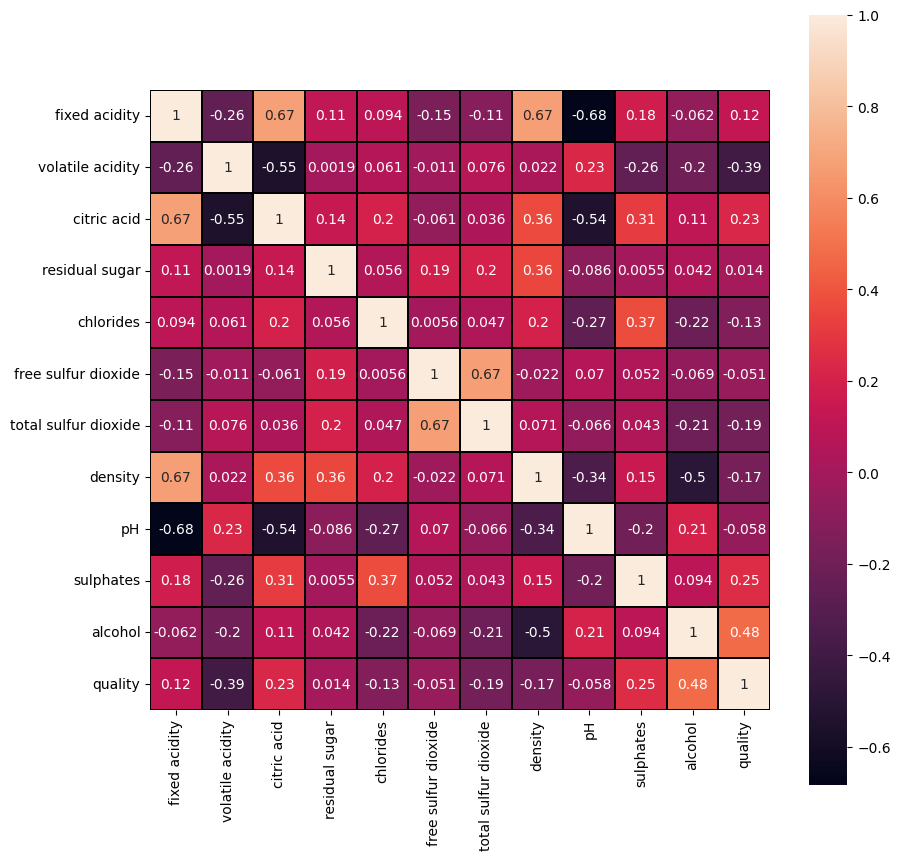

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(data)
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), square = True, annot=True, annot_kws={'fontsize':10}, linewidths=.1, vmax=1, linecolor='black')
plt.show()

Now it's time to get specific about what I consider to be the target. This time, I'd like to mix it up a bit and select a different target. Since it would be nice to see a strong model for once, I'm going to choose fixed acidity, because it has the most strong correlations with the other features.

In [3]:
from sklearn.model_selection import train_test_split

features = data.drop(columns=['fixed acidity'])
target = data['fixed acidity']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.3, random_state= 264)

Before we can do any searching there need to be spaces in which to search. I've chosen a few hyperparameters from each of the regressors I'm using (support vector, gradient boosting, random forest, and decision tree), and additionally the hyperparameters for all of the preprocessing methods. The number of parameters used is displayed in the graph below this cell.\
\
This feels like a good time to explain my choices. For the sake of preprocessing this dataset, I've chosen the MinMaxScaler, the Normalizer, and the PowerTransformer.\
\
The MinMaxScaler just scales the values

In [4]:
#build search spaces
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tabulate import tabulate


copy = [True, False]
clip = [True, False]

norm = ['l1', 'l2', 'max']

standardize = [True, False]

estimators = list(range(300,900))
maxFeatures = ['sqrt', 'log2', None]
minSplit = list(range(2,20))
minLeaf = list(range(1,5))
randomGrid = {'scaler__copy':copy, 'scaler__clip':clip,'normalizer__norm':norm, 'transformer__standardize':standardize, 'regressor__n_estimators':estimators, 'regressor__max_features':maxFeatures, 'regressor__min_samples_split':minSplit, 'regressor__min_samples_leaf':minLeaf}

maxIter = list(range(300,900))
gamma = ['scale', 'auto']
degree = list(range(3,16))

svcGrid = {'scaler__copy':copy, 'scaler__clip':clip, 'normalizer__norm':norm, 'transformer__standardize':standardize, 'regressor__max_iter':maxIter, 'regressor__gamma':gamma, 'regressor__degree':degree}

splitter = ['best', 'random']
maxDepth = list(range(40,115))
dtGrid = {'scaler__copy':copy, 'scaler__clip':clip, 'normalizer__norm':norm, 'transformer__standardize':standardize, 'regressor__splitter':splitter, 'regressor__max_depth':maxDepth, 'regressor__min_samples_split':minSplit, 'regressor__min_samples_leaf':minLeaf}

gbGrid = {'scaler__copy':copy, 'scaler__clip':clip, 'normalizer__norm':norm, 'transformer__standardize':standardize, 'regressor__max_depth':maxDepth, 'regressor__max_features':maxFeatures, 'regressor__min_samples_leaf':minLeaf, 'regressor__min_samples_split':minSplit}

space = [svcGrid, dtGrid, gbGrid, randomGrid]
models = [SVR(), DecisionTreeRegressor(), GradientBoostingRegressor(),RandomForestRegressor()]

searchSpaces = [['Attribute Name', 'Attribute Range'] + models, 
                ['n_estimators', '(450-900)', '', '', '', '450'],
                ['splitter', '(Best, Random)', '', '2', '', ''],
                ['max_depth', '(40-115)', '', '75', '75', ''],
                ['min_samples_split', '(2-20)', '', '18', '18', '18'],
                ['min_samples_leaf', '(1-5)','', '5', '5', '5'],
                ['max_features', '(sqrt, log2, None)','', '', '3', '3'],
                ['gamma', '(Scale, Auto)', '2', '', '', ''],
                ['max_iter', '(300-900)', '600', '', '', ''],
                ['degree', '(3-16)', '13', '', '', ''],
                ['copy', '(True, False)', '2', '2', '2', '2'],
                ['clip', '(True, False)', '2', '2', '2', '2'],
                ['norm', '(l1, l2, max)', '3', '3', '3', '3'],
                ['standardize', '(True, False)', '2', '2', '2', '2'],
                ['feature_range', '(0,1), (0,10), (0,100)', '3', '3', '3', '3'],
                ['', 'Total Combos:', 2*13*600*2*2*2*3*3, 2*75*18*5*2*2*2*3*3, 75*18*5*3*2*2*2*3*3, 450*18*5*3*2*2*2*3*3]]
print(tabulate(searchSpaces, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════════╤════════════════════════╤═════════╤═══════════════════════════╤═══════════════════════════════╤═══════════════════════════╕
│ Attribute Name    │ Attribute Range        │ SVR()   │ DecisionTreeRegressor()   │ GradientBoostingRegressor()   │ RandomForestRegressor()   │
╞═══════════════════╪════════════════════════╪═════════╪═══════════════════════════╪═══════════════════════════════╪═══════════════════════════╡
│ n_estimators      │ (450-900)              │         │                           │                               │ 450                       │
├───────────────────┼────────────────────────┼─────────┼───────────────────────────┼───────────────────────────────┼───────────────────────────┤
│ splitter          │ (Best, Random)         │         │ 2                         │                               │                           │
├───────────────────┼────────────────────────┼─────────┼───────────────────────────┼───────────────────────────────┼──────────────

In [5]:
def build(model, opt):
    model.fit(features_train, target_train)
    pred = model.predict(features_test)
    if(not opt):
        return pred
    else:
        return model

In [6]:
from time import time #I want to know how long they take
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer, PowerTransformer
import warnings
warnings.filterwarnings("ignore")

randScore = 0
randName = ''
randParams = ''
randBest = ''
randTime = 0
i = 0
for model in models:
    currentTime = time()

    search = RandomizedSearchCV(Pipeline([(('scaler', MinMaxScaler())), ('normalizer', Normalizer()), ('transformer', PowerTransformer(method='yeo-johnson')), ('regressor', model)]), 
                                space[i], n_iter=50, scoring='r2', n_jobs=-1, cv=4)
    mean = cross_val_score(search, features, target, scoring='r2', cv=3).mean()
    print(f"average r2 score: {mean}")
    i = i + 1
    totalTime = time() - currentTime
    print(f"{model} took {totalTime}.\n")
    if(mean > randScore):
        randScore = mean
        randName = model
        randTime = totalTime
        randBest = build(search, True)
        randParams = randBest.best_params_

print(f"\nThe best performing model was {randName} with the params {randParams} and an r2 score of {randScore}.")


average r2 score: 0.7215544016898562
SVR() took 6.4979088306427.

average r2 score: 0.5174766223796051
DecisionTreeRegressor() took 0.48891663551330566.

average r2 score: 0.7428954104096134
GradientBoostingRegressor() took 8.623823165893555.

average r2 score: 0.6972290617699487
RandomForestRegressor() took 13.523157358169556.


The best performing model was GradientBoostingRegressor() with the params {'transformer__standardize': True, 'scaler__copy': True, 'scaler__clip': True, 'regressor__min_samples_split': 18, 'regressor__min_samples_leaf': 4, 'regressor__max_features': 'log2', 'regressor__max_depth': 97, 'normalizer__norm': 'l1'} and an r2 score of 0.7428954104096134.


r2 for default: 0.8967495076185779
r2 for optimized: 0.8927749123731407


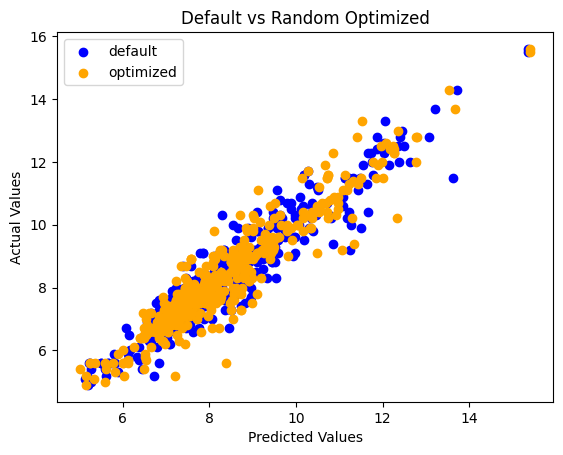

In [7]:
from sklearn.metrics import r2_score

start = time()
word = randName.fit(features_train, target_train)
defaultMean = cross_val_score(word, features, target, cv = 15).mean()
defaultTime = time() - start

rPred = randBest.predict(features_test)
dPred = word.predict(features_test)

print("r2 for default: " + str(r2_score(target_test, dPred)))
print("r2 for optimized: " + str(r2_score(target_test, rPred)))

plt.scatter(dPred, target_test, color='blue', label="default")
plt.scatter(rPred, target_test, color='orange', label="optimized")
plt.legend(loc="upper left")
plt.title("Default vs Random Optimized")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [8]:
#bayesian opt
from skopt import BayesSearchCV

bayesScore = 0
bayesName = ""
bayesParams = ""
bayesTime = 0
bayesBest = ""
i = 0
for model in models:
    currentTime = time()
    #"inner loop" occurs here
    #random forest takes so much longer than the others that I'm giving it its own line with a smaller amount of iterations
    search = BayesSearchCV(Pipeline([(('scaler', MinMaxScaler())), ('normalizer', Normalizer()), ('transformer', PowerTransformer(method='yeo-johnson')), ('regressor', model)]), 
                                space[i], n_iter=50, scoring='r2', n_jobs=-1, cv=4)
    mean = cross_val_score(search, features, target, scoring='r2', cv=3).mean()
    #"outer loop" occurs here
    search.fit(features_train, target_train)
    mean = cross_val_score(search, features, target, cv = 3).mean()
    print("average r2 score: " + str(mean))

    i = i + 1
    totalTime = time() - currentTime
    print("process took " + str(totalTime) + " seconds.\n")
    if(mean > bayesScore):
        bayesScore = mean
        bayesName = model
        bayesBest = build(search,True)
        bayesParams = bayesBest.best_params_
        bayesTime = totalTime
        

print("\nThe best performing model was " + str(bayesName) + " with the parameters " + str(bestBayesParams) + " and a mean accuracy of " + str(bayesScore))

average r2 score: 0.7073063066994459
process took 2.8913686275482178 seconds.

average r2 score: 0.5984192022783116
process took 1.3163776397705078 seconds.

average r2 score: 0.6932455869583256
process took 12.41331672668457 seconds.

average r2 score: 0.6903428756263253
process took 34.758705377578735 seconds.


The best performing model was SVR() with the parameters OrderedDict({'normalizer__norm': 'l1', 'regressor__degree': 8, 'regressor__gamma': 'auto', 'regressor__max_iter': 377, 'scaler__clip': True, 'scaler__copy': False, 'transformer__standardize': False}) and a mean accuracy of 0.7073063066994459


r2 for default: 0.8967495076185779
r2 for optimized: 0.0786573524736287


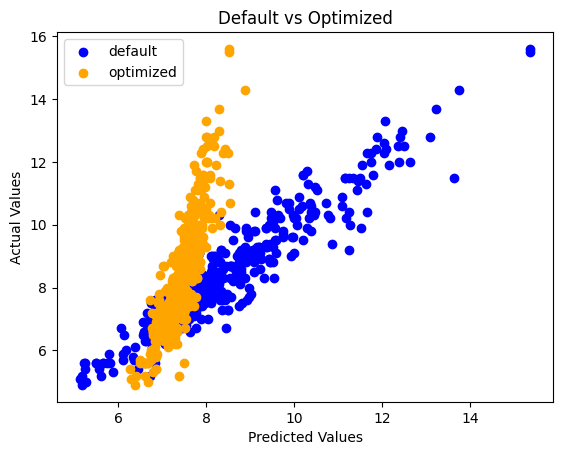

In [9]:
from sklearn.metrics import r2_score

bPred = bayesBest.predict(features_test)

print("r2 for default: " + str(r2_score(target_test, dPred)))
print("r2 for optimized: " + str(r2_score(target_test, bPred)))

plt.scatter(dPred, target_test, color='blue', label="default")
plt.scatter(bPred, target_test, color='orange', label="optimized")
plt.legend(loc="upper left")
plt.title("Default vs Optimized")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

r2 for random: 0.8927749123731407
r2 for Bayesian: 0.0786573524736287


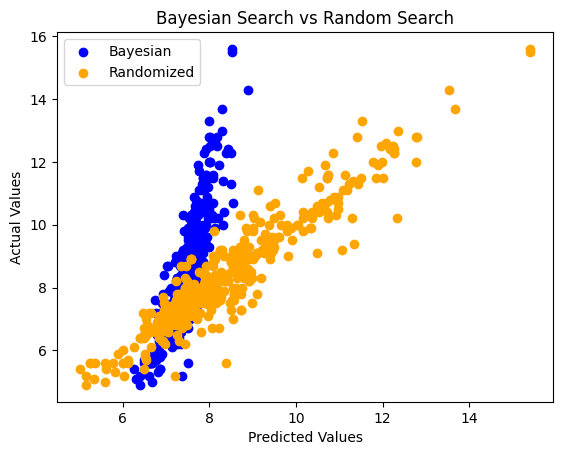

In [10]:
print("r2 for random: " + str(r2_score(target_test, rPred)))
print("r2 for Bayesian: " + str(r2_score(target_test, bPred)))

plt.scatter(bPred, target_test, color='blue', label="Bayesian")
plt.scatter(rPred, target_test, color='orange', label="Randomized")
plt.legend(loc="upper left")
plt.title("Bayesian Search vs Random Search")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [11]:

default = {'transformer__standardize':True, 'scaler__copy':True, 'scaler__clip':True, 'regressor__max_iter':'No Limit', 'regressor__gamma':'scale', 'regressor__degree':3, 'normalizer__norm':'l2', 'scaler__feature_range':(0,1)}

results = [['Param Name', 'Default', 'Random', 'Bayesian']]
for attribute in randParams:
    #print(str(attribute))
    results = results + [[attribute, str(default[attribute]), str(randParams[attribute]), str(bayesParams[str(attribute)])]]
results = results + [['r2 score', defaultMean, str(randScore), str(bayesScore)]]
results = results + [['Runtime', defaultTime, str(randTime), str(bayesTime)]]
print(tabulate(results, headers='firstrow', tablefmt='fancy_grid'))

NameError: name 'bayesParams' is not defined